In [1]:
!which pip

/data/serrano/miniconda3/infinity_env/bin/pip


In [2]:
import airfrans as af
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

In [4]:
import numpy as np

In [5]:
import torch

In [6]:
key_to_index = {
    "x": 0,
    "y": 1,
    "inlet_x": 2,
    "inlet_y": 3,
    "sdf": 4,
    "nx": 5,
    "ny": 6,
    "vx": 7,
    "vy": 8,
    "p": 9,
    "nu":10,
}

In [7]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/INR_domain_decomposition/")

from src.data.dataset import GeometryDataset, KEY_TO_INDEX
from torch_geometric.loader import DataLoader

import einops
import json
import numpy as np
import torch
import torch.nn as nn
from graph_metalearning import outer_step
import yaml
from omegaconf import DictConfig

In [8]:
from experiments.inr import ModulatedPositionalEmbedder, PositionalEmbedder2

/home/serrano/Projects/INR_domain_decomposition/experiments/inr.py:149: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="basic.yaml")


In [9]:
from experiments.inr_sdf import ModulatedPositionalEmbedder as ModulatedPositionalEmbedderSDF

/home/serrano/Projects/INR_domain_decomposition/experiments/inr_sdf.py:139: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config/", config_name="basic.yaml")


# 1. Load pressure results

In [11]:
from wisp.models.embedders import PositionalEmbedder
from coral.siren import LatentToModulation
from src.models.basic_conditioning import film, film_linear, film_translate

In [12]:
dataset_name="airfrans"
data_to_encode="p"
run_name = "still-yogurt-248"
inner_steps = 3

In [39]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [40]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [41]:
scale_factor = cfg_inr.scale_factor
num_frequencies = cfg_inr.num_frequencies
include_sdf = cfg_inr.include_sdf
frequency_embedding = cfg_inr.frequency_embedding
include_input = cfg_inr.include_input
scale = cfg_inr.scale
max_frequencies = cfg_inr.max_frequencies
base_frequency = cfg_inr.base_frequency

In [16]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [23]:
input_dim=2
input_dim = input_dim + 1 if include_sdf else input_dim

inr = ModulatedPositionalEmbedder(input_dim=input_dim,
                                  output_dim=1,
                                  num_frequencies=num_frequencies,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift,
                                  frequency_embedding=frequency_embedding,
                                  include_input=include_input,
                                  scale=scale,
                                  max_frequencies=max_frequencies,
                                  base_frequency=base_frequency).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): FFPositionalEncoding()
  (layers): ModuleList(
    (0): Linear(in_features=258, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=256, out_features=1024, bias=True)
  )
)

In [37]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [42]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|███████████████████████████████████████████████████████████████████| 720/720 [03:19<00:00,  3.60it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|█████████████████████████████████████████████████████████████████████| 80/80 [00:22<00:00,  3.62it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [26]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [27]:
fit_train_mse = 0
for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    graph = graph.cuda()
    if include_sdf:
        graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
print('train', fit_train_mse / ntrain)

train 0.004287848933260344


In [63]:
surface_train_mse = 0
for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    graph = graph.cuda()
    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_train_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('train surface mse', surface_train_mse/ntrain)

train surface mse tensor(0.0011, device='cuda:0')


In [30]:
fit_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    if include_sdf:
        graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples

In [31]:
print('test', fit_test_mse / nval)

test 0.005257400791742839


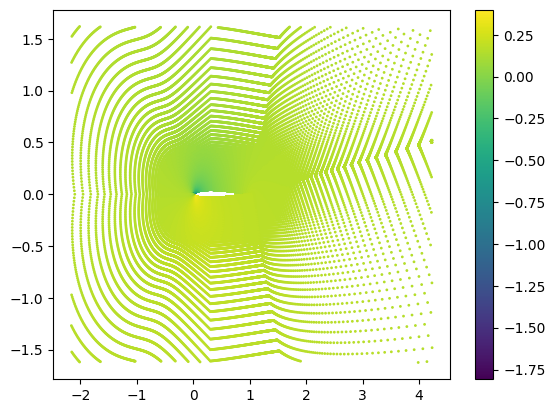

In [32]:
index = 1
mask = graph.batch == index
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

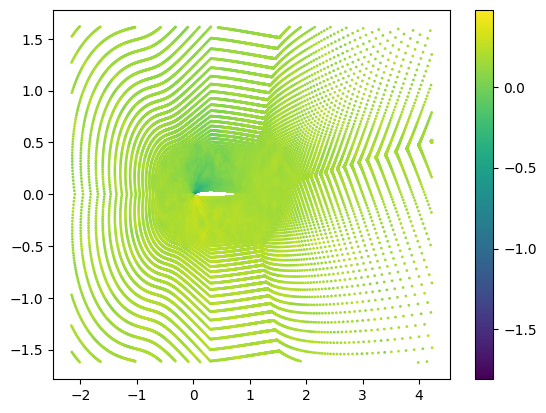

In [33]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [34]:
# zoom on the zone nead the airfoil

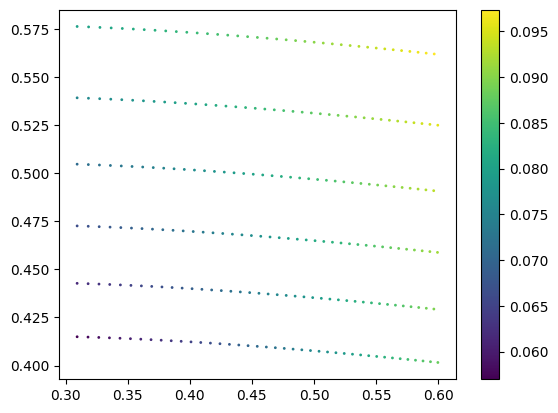

In [35]:
index = 1
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

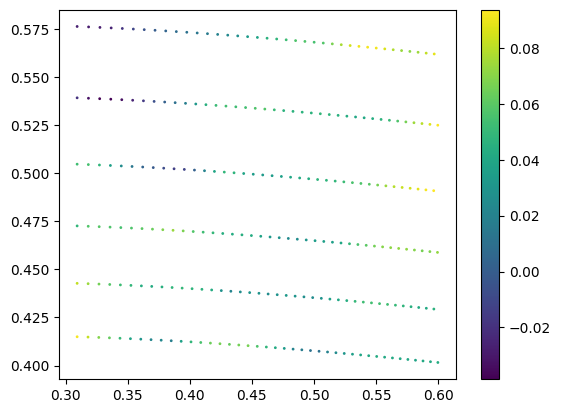

In [36]:
index = 1
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [ ]:
# too much high frequency for the pressure

In [36]:
graph.pos[mask].shape

torch.Size([148046, 2])

In [37]:
# error on the surface

In [39]:
surface_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    if include_sdf:
        graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_test_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('test surface mse', surface_test_mse/nval)

test surface mse tensor(0.0093, device='cuda:0')


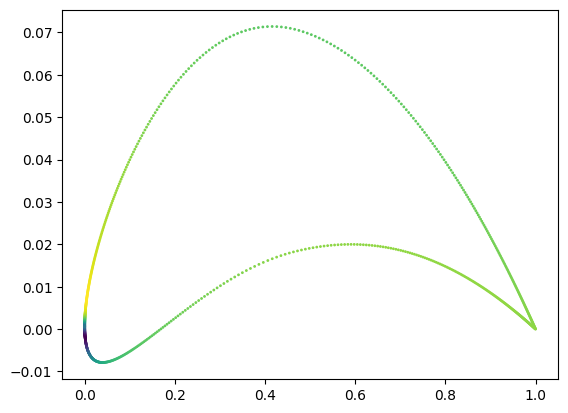

In [40]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=graph.images[mask1&mask2].cpu().detach(), s=1)

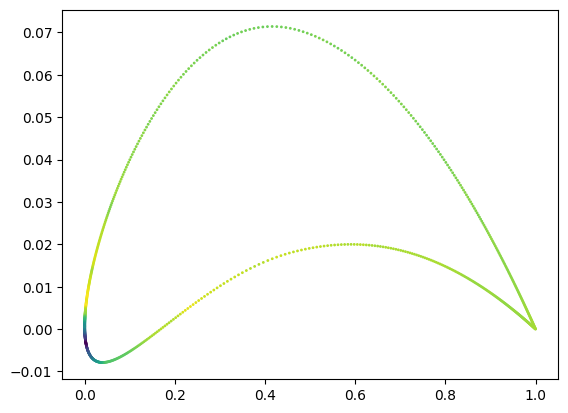

In [41]:
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=features_rec[mask1&mask2].cpu().detach(), s=1)

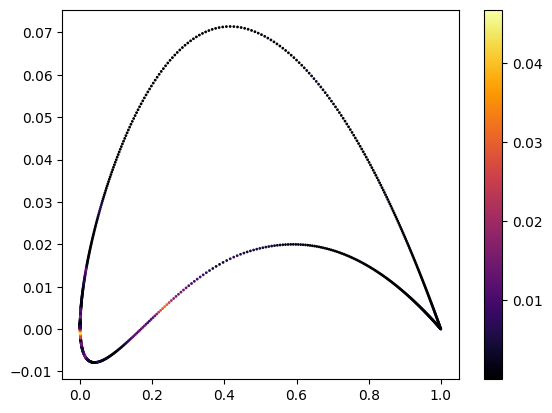

In [42]:
delta = (features_rec - graph.images)**2
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=delta[mask1&mask2].cpu().detach(), s=1, cmap='inferno')
plt.colorbar()

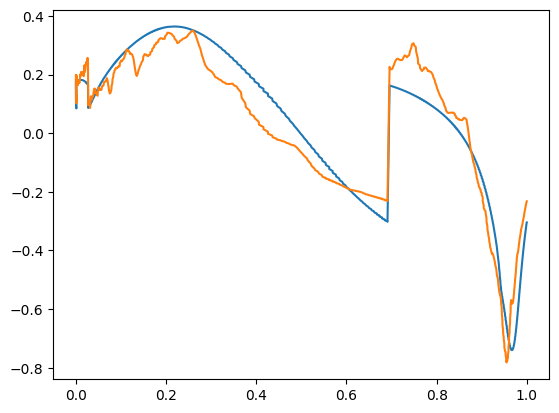

In [43]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

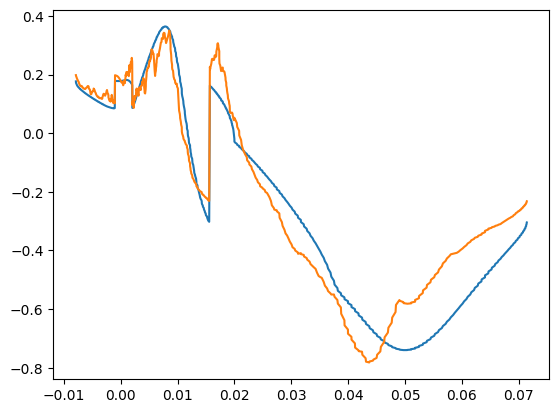

In [44]:
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

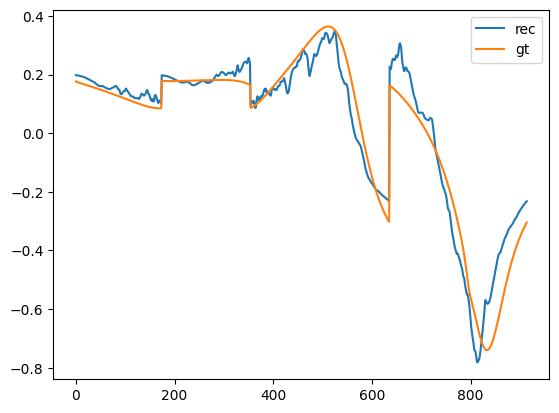

In [45]:
plt.plot(features_rec[mask1&mask2].cpu().detach(), label='rec')
plt.plot(graph.images[mask1&mask2].cpu().detach(), label='gt')
plt.legend()

In [43]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=32, shuffle=True)
device = torch.device("cuda")

In [44]:
from coral.mfn import FFPositionalEncoding

In [45]:
class ModulatedPositionalEncoding(nn.Module):
    def __init__(self, embedding_size, scale, dims=2, gaussian=True):
        super().__init__()
        self.embedding_size = embedding_size
        self.scale = scale

        if gaussian:
            bvals = torch.randn(embedding_size // 2, dims) * scale
        else:
            bvals = 2.0 ** torch.linspace(0, scale, embedding_size // 2) - 1

            if dims == 1:
                bvals = bvals[:, None]

            elif dims == 2:
                bvals = torch.stack([bvals, torch.zeros_like(bvals)], dim=-1)
                bvals = torch.cat([bvals, torch.roll(bvals, 1, -1)], dim=0)

            else:
                tmp = (dims - 1) * (torch.zeros_like(bvals),)
                bvals = torch.stack([bvals, *tmp], dim=-1)

                tmp = [torch.roll(bvals, i, -1) for i in range(1, dims)]
                bvals = torch.cat([bvals, *tmp], dim=0)

        avals = torch.ones((bvals.shape[0]))
        self.avals = nn.Parameter(avals, requires_grad=False)
        self.bvals = nn.Parameter(bvals, requires_grad=False)

    def forward(self, tensor, params) -> torch.Tensor:
        """
        Apply positional encoding to the input.
        """

        return torch.cat(
            [
                self.avals * torch.sin((2.0 * np.pi * tensor) @ self.bvals.T + params),
                self.avals * torch.cos((2.0 * np.pi * tensor) @ self.bvals.T + params),
            ],
            dim=-1,
        )

In [93]:
class ModulatedPositionalEmbedder2(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, num_frequencies=8, latent_dim=128,  width=256, depth=3, modulate_scale=False, modulate_shift=True, frequency_embedding="nerf", include_input=True, scale=5, max_frequencies=32, base_frequency=1.25):
        super().__init__()
        self.frequency_embedding = frequency_embedding
        self.include_input = include_input
        self.num_frequencies = num_frequencies
        if frequency_embedding == "nerf":
            self.embedding = PositionalEmbedder2(num_frequencies, max_frequencies, log_sampling=True, include_input=include_input, input_dim=input_dim, base_freq=base_frequency)
            self.in_channels = [self.embedding.out_dim] + [width]*(depth-1)

        elif frequency_embedding == "gaussian":
            self.scale = scale
            #self.embedding = FFPositionalEncoding(embedding_size=num_frequencies*2, scale=scale, dims=input_dim)
            self.embedding = ModulatedPositionalEncoding(embedding_size=num_frequencies*2, scale=scale, dims=input_dim)
            embed_dim = num_frequencies*2 + input_dim if include_input else num_frequencies*2
            self.in_channels = [embed_dim] + [width]*(depth-1)
            
        self.out_channels = [width]*(depth-1) + [output_dim]
        self.latent_dim = latent_dim
        self.layers = nn.ModuleList([nn.Linear(self.in_channels[k], self.out_channels[k]) for k in range(depth)])
        self.depth=depth
        self.hidden_dim = width

        self.num_modulations = self.hidden_dim * (self.depth-1)
        if modulate_scale and modulate_shift:
            # If we modulate both scale and shift, we have twice the number of
            # modulations at every layer and feature
            self.num_modulations *= 2
        self.num_modulations += self.num_frequencies
        
        self.latent_to_modulation = LatentToModulation(self.latent_dim, self.num_modulations, dim_hidden=256, num_layers=1)

        if modulate_shift and modulate_scale:
            self.conditioning = film
        elif modulate_scale and not modulate_shift: 
            self.conditioning = film_linear
        else:
            self.conditioning = film_translate

    def modulated_forward(self, x, z):
        features = self.latent_to_modulation(z)
        position = self.embedding(x)#, features[..., :self.num_frequencies])
        if self.frequency_embedding == "gaussian" and self.include_input:
            position = torch.cat([position, x], axis=-1)
        pre_out = self.conditioning(position, features[..., self.num_frequencies:], self.layers[:-1], torch.relu)
        out = self.layers[-1](pre_out)
        return out

In [80]:
input_dim=2
include_sdf=False
input_dim = input_dim + 1 if include_sdf else input_dim
frequency_embedding="gaussian"
include_input=True
scale=0.1
num_frequencies=128
max_frequencies=32
base_frequency=2
depth=6
hidden_dim=64
modulate_scale=False


inr = ModulatedPositionalEmbedder2(input_dim=input_dim,
                                  output_dim=1,
                                  num_frequencies=num_frequencies,
                                  latent_dim=256,
                                  width=256,
                                  depth=4,
                                  modulate_scale=True,
                                  modulate_shift=False,
                                  frequency_embedding=frequency_embedding,
                                  include_input=include_input,
                                  scale=scale,
                                  max_frequencies=max_frequencies,
                                  base_frequency=base_frequency).cuda()
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-3)

In [61]:
for graph, idx in train_loader:
    break

In [62]:
graph

DataBatch(pos=[5780219, 2], surface=[5780219], sdf=[5780219, 1], modulations=[32, 256], images=[5780219, 1], batch=[5780219], ptr=[33])

In [63]:
from copy import deepcopy

In [81]:
def get_sub_graph(graph, idx, n_points=8000):
    sub_graph = deepcopy(graph)
    sub_coords = []
    sub_images = []
    sub_sdf = []
    sub_batch = []
    
    for k in range(len(idx)):
        coords = graph.pos[graph.batch==k]
        surface = graph.surface[graph.batch==k]
        images = graph.images[graph.batch==k]
        sdf = graph.sdf[graph.batch==k]
        batch = graph.batch[graph.batch==k]
        
        mask = torch.randperm(coords.shape[0])[:n_points]
        mask = torch.cat([mask, torch.arange(surface.shape[0])[surface]]) 
        sub_coords.append(coords[mask])
        sub_images.append(images[mask])
        sub_sdf.append(sdf[mask])
        sub_batch.append(batch[mask])
        
    sub_graph.pos = torch.cat(sub_coords, axis=0)
    sub_graph.images = torch.cat(sub_images, axis=0)
    sub_graph.sdf = torch.cat(sub_sdf, axis=0)
    sub_graph.batch = torch.cat(sub_batch, axis=0)
    
    return sub_graph
        

In [65]:
epochs=1000

for step in range(epochs):
    sub_graph = get_sub_graph(graph, idx)
    sub_graph = sub_graph.cuda()
    if include_sdf:
        sub_graph.pos = torch.cat([sub_graph.pos, sub_graph.sdf], axis=-1)
    
    outputs = outer_step(
        inr,
        sub_graph,
        inner_steps,
        0.01,
        is_train=True,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    optimizer.zero_grad()
    outputs['loss'].backward(create_graph=False)
    optimizer.step()
    loss = outputs['loss'].item()
    if step%20==0:
        print(step, loss)

0 0.5750902891159058
20 0.5728623270988464
40 0.5762742757797241
60 0.5778603553771973
80 0.5436997413635254
100 0.5054436326026917
120 0.46392032504081726
140 0.40294232964515686
160 0.32831528782844543
180 0.26912105083465576
200 0.49504169821739197
220 0.5364391207695007
240 0.49995502829551697
260 0.4911107122898102
280 0.46699821949005127
300 0.3742641508579254
320 0.3447471857070923
340 inf
360 nan
380 nan
400 nan
420 nan
440 nan
460 nan
480 nan
500 nan
520 nan
540 nan
560 nan
580 nan
600 nan
620 nan


KeyboardInterrupt: 

In [54]:
modulations = outputs['modulations']

In [55]:
index = 2
mask = graph.batch == index
if include_sdf:
    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    
with torch.no_grad():
    pred = inr.modulated_forward(graph.pos[mask].cuda(), modulations[index].unsqueeze(0))

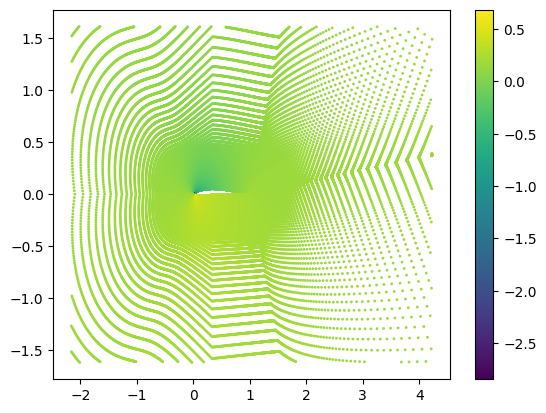

In [56]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

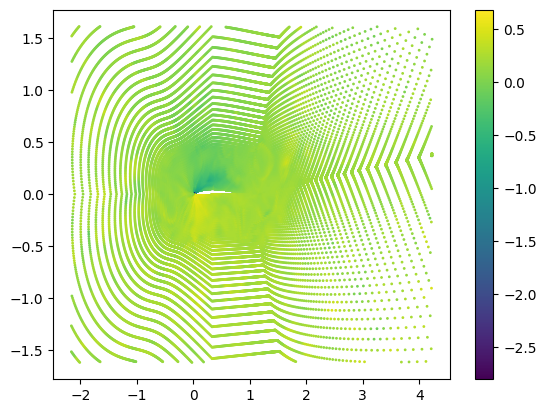

In [57]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=pred.cpu().detach(), s=1)
plt.colorbar()

In [84]:
x = torch.randn(100)

In [87]:
x[x.argsort()[-10:]]

tensor([1.3184, 1.3302, 1.4034, 1.4269, 1.4664, 1.5095, 1.5663, 1.8512, 1.9936,
        2.1293])

In [94]:
from collections import OrderedDict
from functools import partial

import einops
import coral.losses as losses
import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch import autograd
from torch.nn.parallel import DistributedDataParallel as DDP


def inner_loop(
    func_rep,
    modulations,
    coordinates,
    features,
    batch_index,
    n_samples,
    inner_steps,
    inner_lr,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    topK=0.25
):
    """Performs inner loop, i.e. fits modulations such that the function
    representation can match the target features.

    Args:
        func_rep (models.ModulatedSiren):
        modulations (torch.Tensor): Shape (batch_size, latent_dim).
        coordinates (torch.Tensor): Coordinates at which function representation
            should be evaluated. Shape (batch_size, *, coordinate_dim).
        features (torch.Tensor): Target features for model to match. Shape
            (batch_size, *, feature_dim).
        inner_steps (int): Number of inner loop steps to take.
        inner_lr (float): Learning rate for inner loop.
        is_train (bool):
        gradient_checkpointing (bool): If True uses gradient checkpointing. This
            can massively reduce memory consumption.
    """
    fitted_modulations = modulations
    for step in range(inner_steps):
        if gradient_checkpointing:
            fitted_modulations = cp.checkpoint(
                inner_loop_step,
                func_rep,
                fitted_modulations,
                coordinates,
                features,
                torch.as_tensor(inner_lr),
                torch.as_tensor(is_train),
                torch.as_tensor(gradient_checkpointing),
                loss_type,
                topK
            )
        else:
            fitted_modulations = inner_loop_step(
                func_rep,
                fitted_modulations,
                coordinates,
                features,
                batch_index,
                n_samples,
                inner_lr,
                is_train,
                gradient_checkpointing,
                loss_type,
                topK
            )
    return fitted_modulations


def inner_loop_step(
    func_rep,
    modulations,
    coordinates,
    features,
    batch_index,
    n_samples,
    inner_lr,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    topK=0.25
):
    """Performs a single inner loop step."""
    detach = not torch.is_grad_enabled() and gradient_checkpointing

    if loss_type == "mse":
        element_loss_fn = losses.per_element_mse_fn
    elif loss_type == "bce":
        element_loss_fn = losses.per_element_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        element_loss_fn = partial(
            losses.per_element_multi_scale_fn,
            loss_name=loss_name,
            last_element=False,
        )
    
    with torch.no_grad():
        initial_pred = func_rep.modulated_forward(coordinates, modulations[batch_index])
        mask = element_loss_fn(initial_pred, features).squeeze().argsort()[-int(topK*coordinates.shape[0]):]

    with torch.enable_grad():
        # Note we multiply by batch size here to undo the averaging across batch
        # elements from the MSE function. Indeed, each set of modulations is fit
        # independently and the size of the gradient should not depend on how
        # many elements are in the batch
        features_recon = func_rep.modulated_forward(coordinates[mask], modulations[batch_index[mask]])
        loss = element_loss_fn(features_recon, features[mask]).mean() * n_samples

        # If we are training, we should create graph since we will need this to
        # compute second order gradients in the MAML outer loop
        grad = torch.autograd.grad(
            loss,
            modulations,
            create_graph=is_train and not detach,
        )[0]
        # if clip_grad_value is not None:
        #    nn.utils.clip_grad_value_(grad, clip_grad_value)
    # Perform single gradient descent step
    return modulations - inner_lr * grad


def outer_step(
    func_rep,
    graph,
    inner_steps,
    inner_lr,
    is_train=False,
    return_reconstructions=False,
    gradient_checkpointing=False,
    loss_type="mse",
    use_rel_loss=False,
    topK=0.25
):
    """

    Args:
        coordinates (torch.Tensor): Shape (batch_size, *, coordinate_dim). Note this
            _must_ have a batch dimension.
        features (torch.Tensor): Shape (batch_size, *, feature_dim). Note this _must_
            have a batch dimension.
    """

    if loss_type == "mse":
        loss_fn = torch.nn.MSELoss()
    elif loss_type == "bce":
        loss_fn = torch.nn.BCEWithLogitsLoss()
    func_rep.zero_grad()
    if isinstance(func_rep, DDP):
        func_rep = func_rep.module

    modulations = torch.zeros_like(graph.modulations).requires_grad_()
    n_samples = len(graph)
    batch_index = graph.batch
    features = graph.images.clone()
    coordinates = graph.pos.clone()

    # Run inner loop
    modulations = inner_loop(
        func_rep,
        modulations,
        coordinates,
        features,
        batch_index,
        n_samples,
        inner_steps,
        inner_lr,
        is_train,
        gradient_checkpointing,
        loss_type,
        topK
    )

    with torch.set_grad_enabled(is_train):
        features_recon = func_rep.modulated_forward(coordinates, modulations[batch_index])
        per_example_loss = loss_fn(features_recon, features)  # features
        loss = per_example_loss.mean()

    outputs = {
        "loss": loss,
        "psnr": losses.mse2psnr(per_example_loss).mean().item(),
        "modulations": modulations,
    }

    if return_reconstructions:
        outputs["reconstructions"] = (
            features_recon[-1] if "multiscale" in loss_type else features_recon
        )

    if use_rel_loss:
        rel_loss = (
            losses.batch_mse_rel_fn(features_recon[-1], features).mean()
            if "multiscale" in loss_type
            else losses.batch_mse_rel_fn(features_recon, features).mean()
        )
        outputs["rel_loss"] = rel_loss

    return outputs


In [97]:
input_dim=2
include_sdf=False
input_dim = input_dim + 1 if include_sdf else input_dim
frequency_embedding="nerf"
include_input=True
scale=1
num_frequencies=128
max_frequencies=32
base_frequency=2
depth=6
hidden_dim=64
modulate_scale=False


inr = ModulatedPositionalEmbedder2(input_dim=input_dim,
                                  output_dim=1,
                                  num_frequencies=num_frequencies,
                                  latent_dim=256,
                                  width=256,
                                  depth=3,
                                  modulate_scale=True,
                                  modulate_shift=False,
                                  frequency_embedding=frequency_embedding,
                                  include_input=include_input,
                                  scale=scale,
                                  max_frequencies=max_frequencies,
                                  base_frequency=base_frequency).cuda()
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [99]:
epochs=1000

for step in range(epochs):
    sub_graph = get_sub_graph(graph, idx)
    sub_graph = sub_graph.cuda()
    if include_sdf:
        sub_graph.pos = torch.cat([sub_graph.pos, sub_graph.sdf], axis=-1)
    
    outputs = outer_step(
        inr,
        sub_graph,
        inner_steps,
        0.1,
        is_train=True,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
        topK=0.2
    )
    optimizer.zero_grad()
    outputs['loss'].backward(create_graph=False)
    optimizer.step()
    loss = outputs['loss'].item()
    if step%20==0:
        print(step, loss)

OutOfMemoryError: CUDA out of memory. Tried to allocate 706.00 MiB (GPU 0; 23.69 GiB total capacity; 21.79 GiB already allocated; 76.69 MiB free; 22.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# 2. Nu

In [45]:
dataset_name="airfrans"
data_to_encode="nu"
run_name = "charmed-mountain-167"
inner_steps = 3

In [46]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [47]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [48]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [49]:
inr = ModulatedPositionalEmbedder(input_dim=2,
                                  output_dim=1,
                                  num_frequencies=8,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder()
  (layers): ModuleList(
    (0): Linear(in_features=34, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=512, out_features=1024, bias=True)
  )
)

In [50]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [51]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [03:14<00:00,  3.70it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:20<00:00,  3.93it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [52]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [53]:
fit_train_mse = 0
for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
print('train', fit_train_mse / ntrain)

train 0.002323530462551086


In [54]:
surface_train_mse = 0
for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_train_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('train surface mse', surface_train_mse/ntrain)

train surface mse tensor(0.0026, device='cuda:0')


In [55]:
fit_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples

In [56]:
print('test', fit_test_mse / nval)

test 0.0041135325707728045


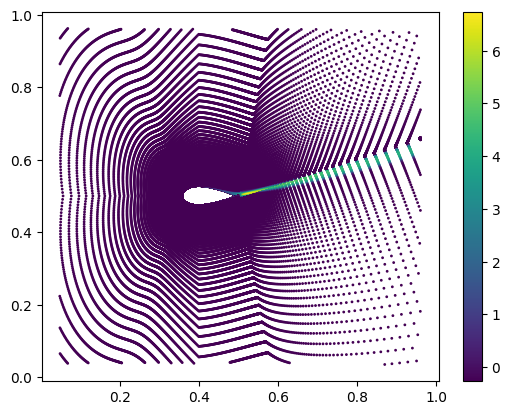

In [59]:
index = 0
mask = graph.batch == index
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

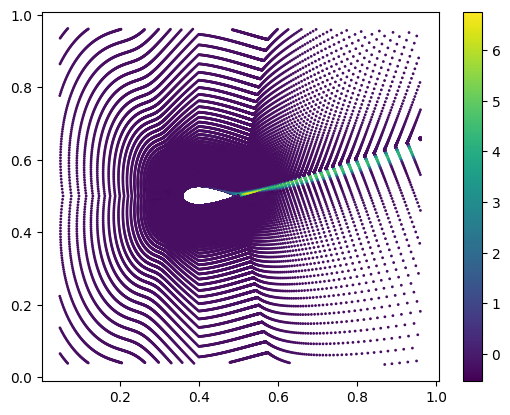

In [60]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [63]:
# hard to know what should be done to improve nu. Maybe we should zoom on the trail

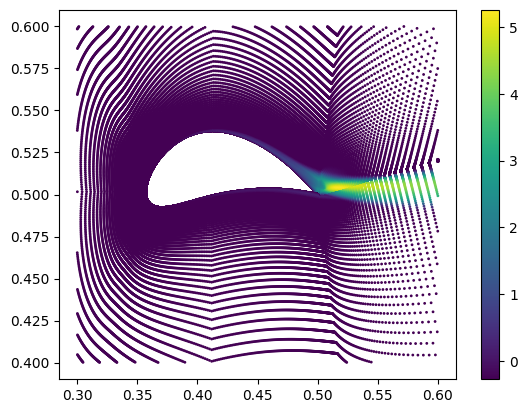

In [61]:
index = 1
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

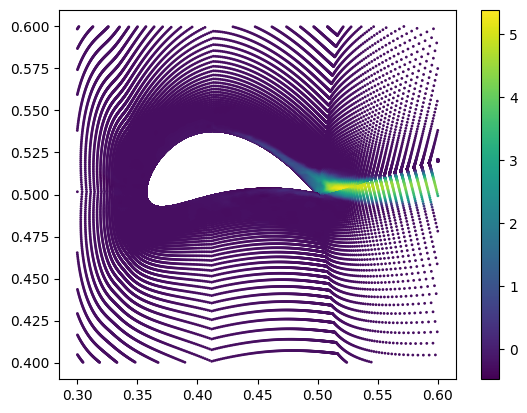

In [62]:
index = 1
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [64]:
# too much high frequency for the pressure

In [65]:
# error on the surface

In [66]:
surface_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_test_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('test surface mse', surface_test_mse/nval)

test surface mse tensor(0.0043, device='cuda:0')


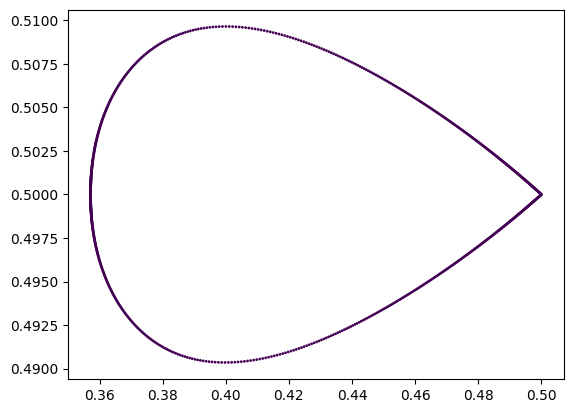

In [67]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=graph.images[mask1&mask2].cpu().detach(), s=1)

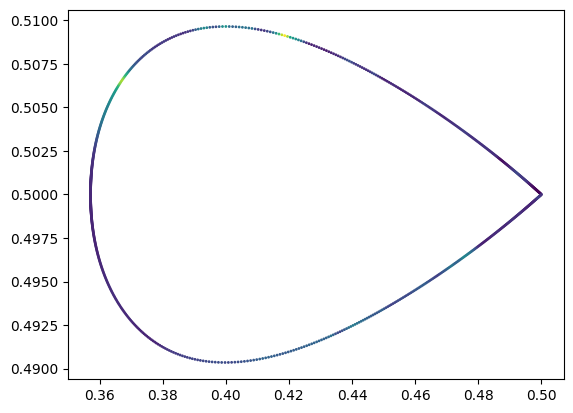

In [68]:
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=features_rec[mask1&mask2].cpu().detach(), s=1)

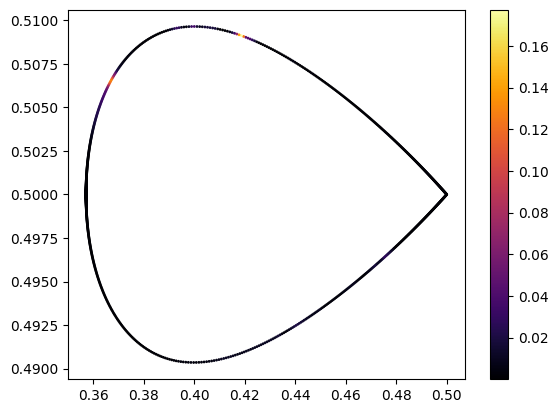

In [69]:
delta = (features_rec - graph.images)**2
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=delta[mask1&mask2].cpu().detach(), s=1, cmap='inferno')
plt.colorbar()

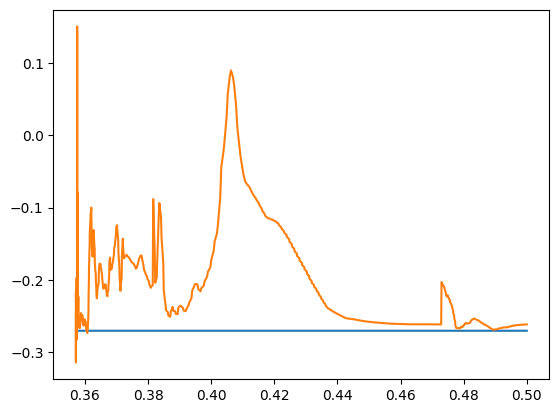

In [70]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

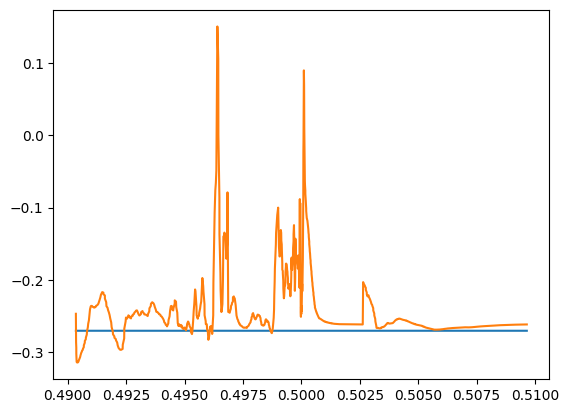

In [71]:
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

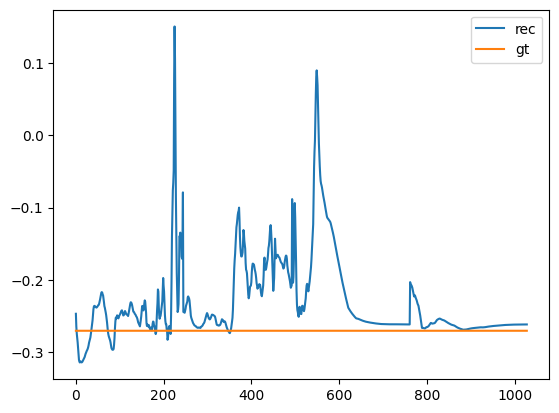

In [72]:
plt.plot(features_rec[mask1&mask2].cpu().detach(), label='rec')
plt.plot(graph.images[mask1&mask2].cpu().detach(), label='gt')
plt.legend()

# 3. Vy

In [10]:
from wisp.models.embedders import PositionalEmbedder
from coral.siren import LatentToModulation
from src.models.basic_conditioning import film, film_linear, film_translate

In [73]:
dataset_name="airfrans"
data_to_encode="vy"
run_name = "dazzling-disco-169"
inner_steps = 3

In [74]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [75]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [76]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [77]:
inr = ModulatedPositionalEmbedder(input_dim=2,
                                  output_dim=1,
                                  num_frequencies=8,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder()
  (layers): ModuleList(
    (0): Linear(in_features=34, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=512, out_features=1024, bias=True)
  )
)

In [78]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [79]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:22<00:00,  2.74it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:27<00:00,  2.92it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [80]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [81]:
fit_train_mse = 0
surface_train_mse = 0

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
    
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_train_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('train', fit_train_mse / ntrain)
print('train surface mse', surface_train_mse/ntrain)

train 0.00468263438168732
train surface mse tensor(0.1078, device='cuda:0')


In [82]:
fit_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples

In [83]:
print('test', fit_test_mse / nval)

test 0.00818546069203876


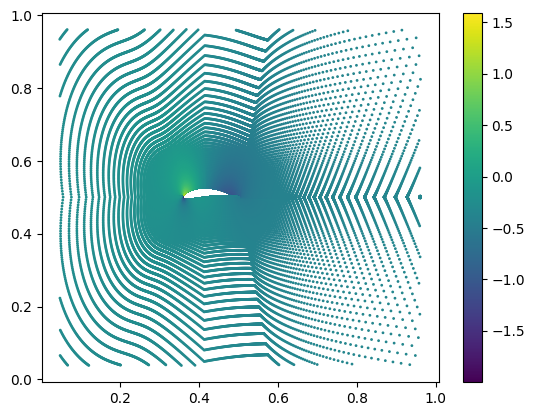

In [84]:
index = 1
mask = graph.batch == index
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

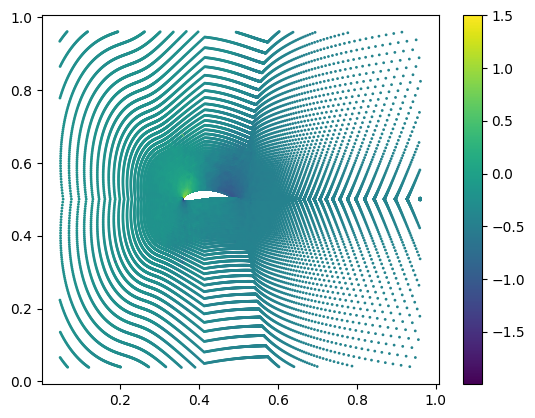

In [85]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [31]:
# zoom on the zone nead the airfoil

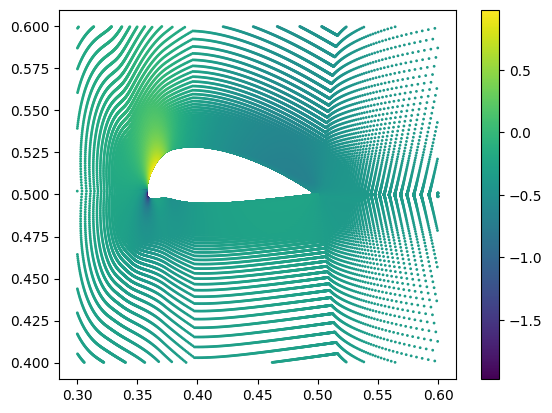

In [98]:
index = 0
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

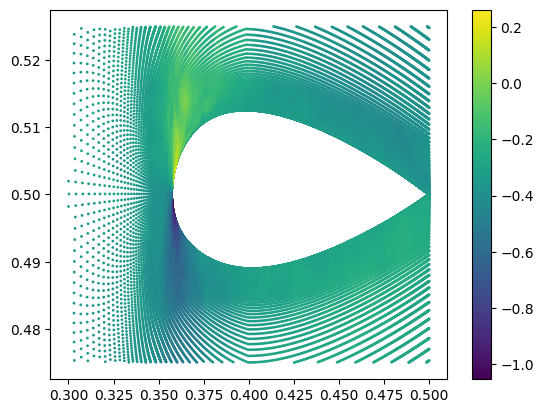

In [115]:
index = 0
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.5, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.525, graph.pos[..., 1] > 0.475)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [100]:
# error on the surface

In [101]:
surface_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_test_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('test surface mse', surface_test_mse/nval)

test surface mse tensor(0.1407, device='cuda:0')


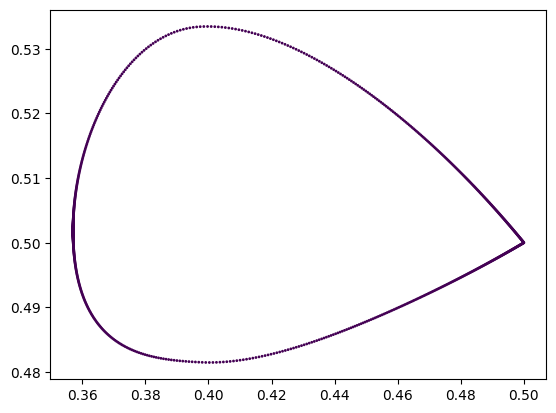

In [102]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=graph.images[mask1&mask2].cpu().detach(), s=1)

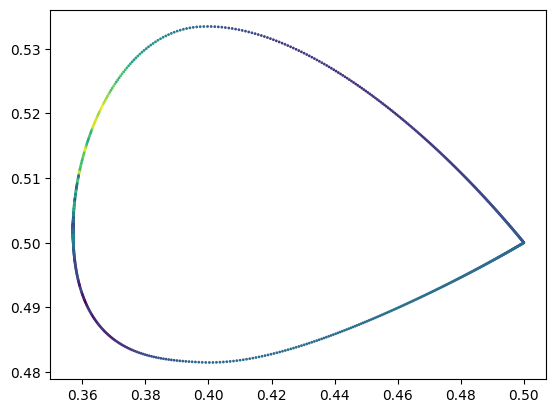

In [103]:
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=features_rec[mask1&mask2].cpu().detach(), s=1)

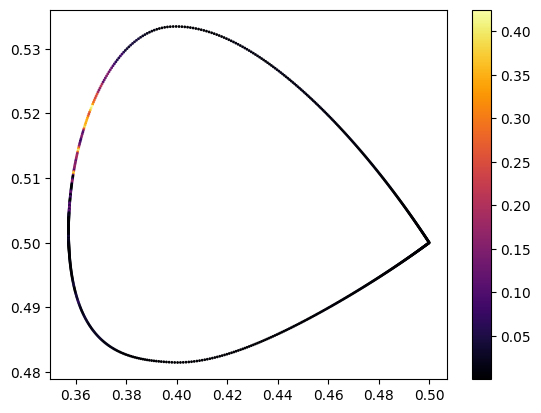

In [108]:
delta = (features_rec - graph.images)**2
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=delta[mask1&mask2].cpu().detach(), s=1, cmap='inferno')
plt.colorbar()

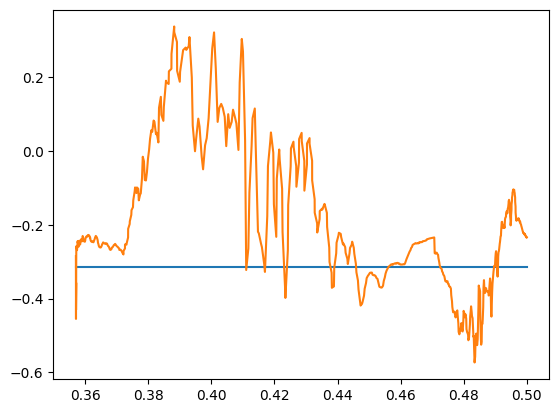

In [109]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

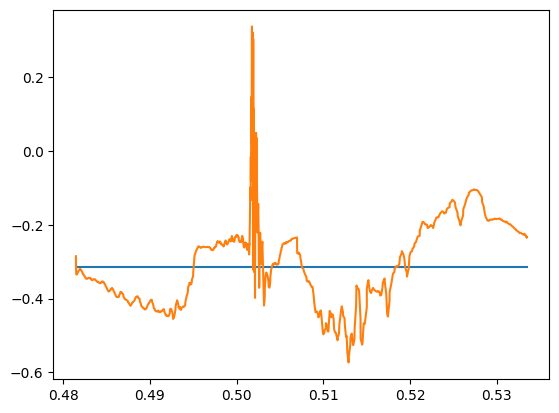

In [110]:
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

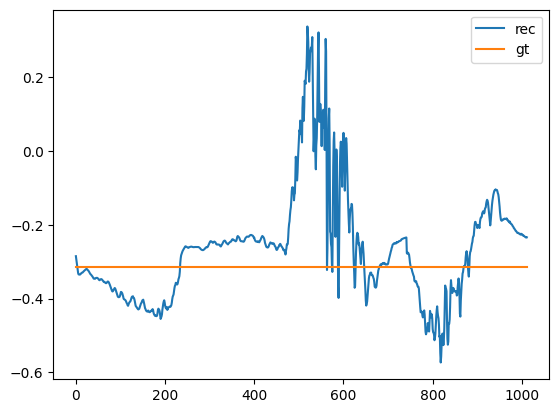

In [111]:
plt.plot(features_rec[mask1&mask2].cpu().detach(), label='rec')
plt.plot(graph.images[mask1&mask2].cpu().detach(), label='gt')
plt.legend()

# 4. vx

In [45]:
dataset_name="airfrans"
data_to_encode="vx"
run_name = "iconic-vortex-198"
inner_steps = 3

In [46]:
inr_train = torch.load(f"/data/serrano/functa2functa/airfrans/inr/{data_to_encode}/{run_name}.pt")

In [47]:
inr_state_dict = inr_train['inr']
cfg_inr = inr_train['cfg_inr']
alpha = inr_train['alpha']
data = inr_train['data']

In [48]:
data_dir = "/data/serrano/deeponet-fourier-data/"
task = "full"

In [49]:
inr = ModulatedPositionalEmbedder(input_dim=3,
                                  output_dim=1,
                                  num_frequencies=32,
                                  latent_dim=cfg_inr.latent_dim,
                                  width=cfg_inr.hidden_dim,
                                  depth=cfg_inr.depth,
                                  modulate_scale=cfg_inr.modulate_scale,
                                  modulate_shift=cfg_inr.modulate_shift).cuda()
inr.load_state_dict(inr_state_dict)
inr.eval()

ModulatedPositionalEmbedder(
  (embedding): PositionalEmbedder2()
  (layers): ModuleList(
    (0): Linear(in_features=192, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
  (latent_to_modulation): LatentToModulation(
    (net): Linear(in_features=512, out_features=1024, bias=True)
  )
)

In [50]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [51]:
#default sample is none
latent_dim = cfg_inr.latent_dim
batch_size = 4
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset.coef_norm)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [04:05<00:00,  2.94it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:24<00:00,  3.29it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [52]:
train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=2, shuffle=True)
device = torch.device("cuda")

In [53]:
fit_train_mse = 0
surface_train_mse = 0

for substep, (graph, idx) in enumerate(train_loader):
    inr.eval()
    graph = graph.cuda()
    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_train_mse += loss.item() * n_samples
    
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_train_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('train', fit_train_mse / ntrain)
print('train surface mse', surface_train_mse/ntrain)

train 0.000320222630277082
train surface mse tensor(0.0007, device='cuda:0')


In [68]:
fit_test_mse = 0
surface_test_mse = 0
for substep, (graph, idx) in enumerate(val_loader):
    inr.eval()
    graph = graph.cuda()
    graph.pos = torch.cat([graph.pos, graph.sdf], axis=-1)
    n_samples = len(graph)

    outputs = outer_step(
        inr,
        graph,
        inner_steps,
        alpha,
        is_train=False,
        return_reconstructions=True,
        gradient_checkpointing=False,
        use_rel_loss=False,
        loss_type="mse",
    )
    
    loss = outputs["loss"].cpu().detach()
    fit_test_mse += loss.item() * n_samples
    
    mask = graph.surface
    features_rec = outputs['reconstructions']
    surface_test_mse += ((features_rec[mask] - graph.images[mask])**2).mean()*n_samples
    
print('test', fit_test_mse / nval)
print('test surface mse', surface_test_mse/nval)

test 0.0004225403667078353
test surface mse tensor(0.0007, device='cuda:0')


In [69]:
print('test', fit_test_mse / nval)

test 0.0004225403667078353


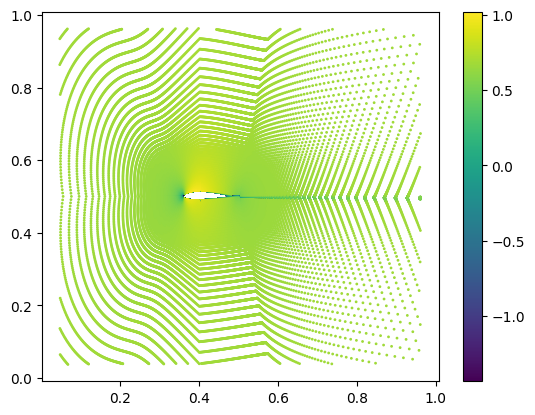

In [75]:
index = 0
mask = graph.batch == index
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

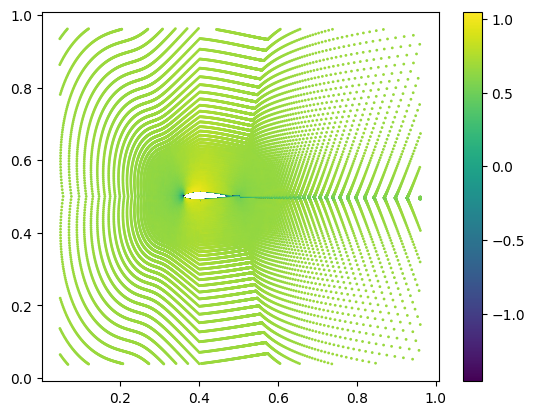

In [76]:
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [77]:
# zoom on the zone nead the airfoil

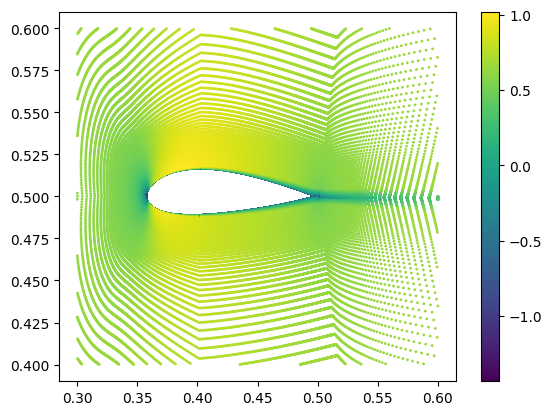

In [78]:
index = 0
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=graph.images[mask].cpu().detach(), s=1)
plt.colorbar()

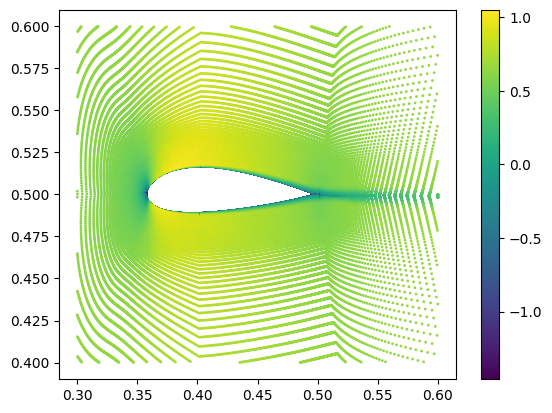

In [79]:
index = 0
mask1 = graph.batch == index
mask2 = torch.logical_and(graph.pos[..., 0] < 0.6, graph.pos[..., 0] > 0.3)
mask3 = torch.logical_and(graph.pos[..., 1] < 0.6, graph.pos[..., 1] > 0.4)
mask = mask1 & mask2 & mask3
plt.scatter(graph.pos[mask, 0].cpu().detach(), graph.pos[mask, 1].cpu().detach(), c=outputs['reconstructions'][mask].cpu().detach(), s=1)
plt.colorbar()

In [133]:
# error on the surface

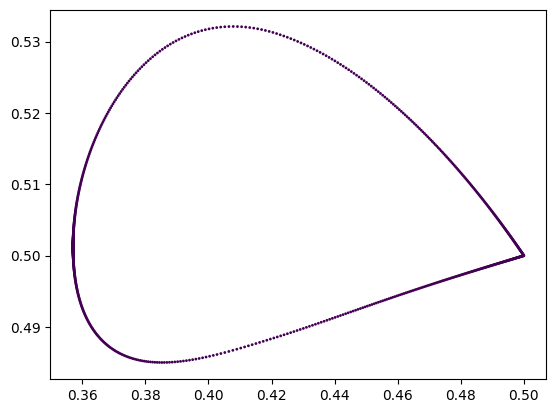

In [80]:
index = 1
mask1 = graph.batch == index
mask2 = graph.surface
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=graph.images[mask1&mask2].cpu().detach(), s=1)

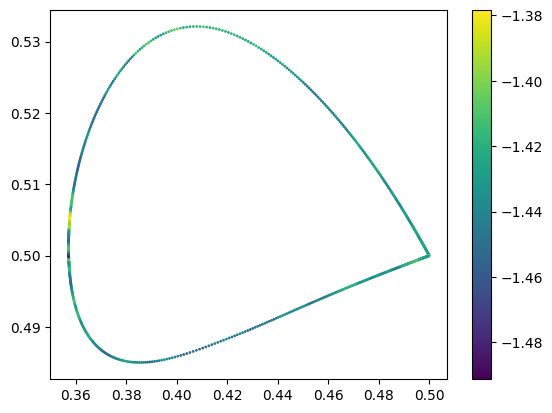

In [82]:
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=features_rec[mask1&mask2].cpu().detach(), s=1)
plt.colorbar()

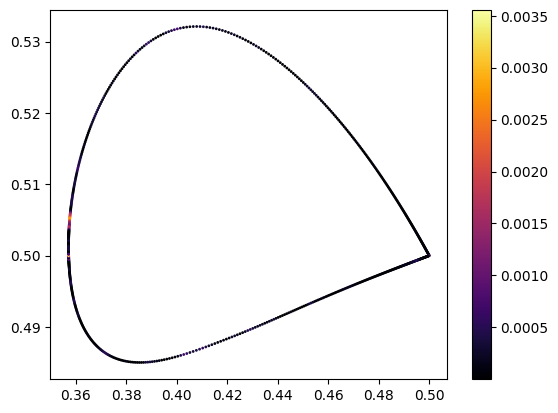

In [83]:
delta = (features_rec - graph.images)**2
plt.scatter(graph.pos[mask1&mask2, 0].cpu().detach(), graph.pos[mask1&mask2, 1].cpu().detach(), c=delta[mask1&mask2].cpu().detach(), s=1, cmap='inferno')
plt.colorbar()

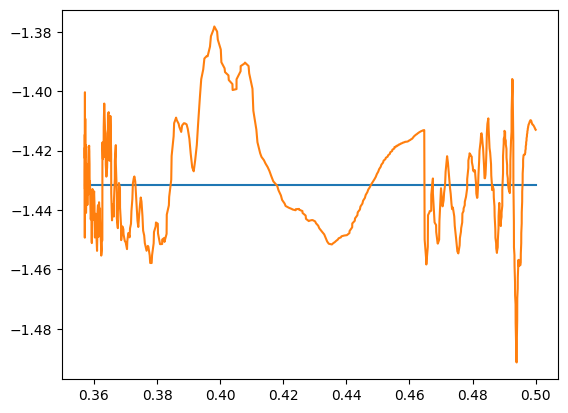

In [84]:
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 0].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

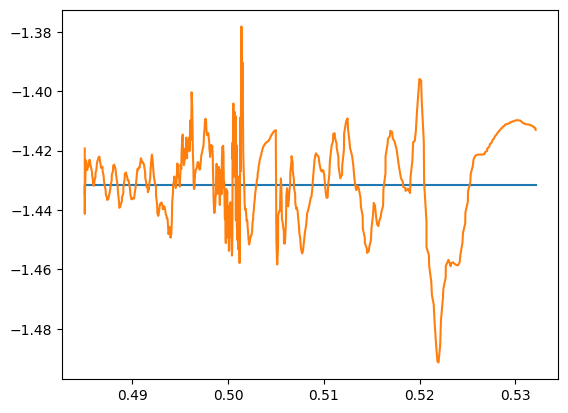

In [85]:
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0],graph.images[mask1&mask2].cpu().detach())
plt.plot(graph.pos[mask1&mask2, 1].cpu().detach().sort()[0], features_rec[mask1&mask2].cpu().detach())

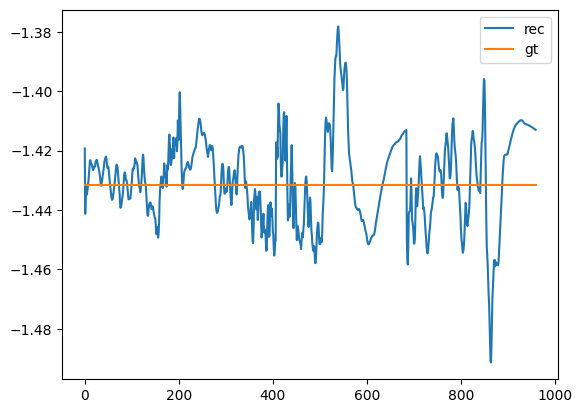

In [86]:
plt.plot(features_rec[mask1&mask2].cpu().detach(), label='rec')
plt.plot(graph.images[mask1&mask2].cpu().detach(), label='gt')
plt.legend()

In [57]:
trainset = manifest_train[:20] # was [:-n] ???
valset = manifest_train[-20:]

In [315]:
with open('../config/wisp_hash.yaml', 'r') as f:
    wisp_cfg = yaml.safe_load(f)
wisp_cfg = DictConfig(wisp_cfg)

In [316]:
#wisp_cfg.nef.pos_embedder = 'positional'

In [317]:
torch.cuda.empty_cache()

In [333]:
nef = load_neural_field(wisp_cfg).cuda()

In [334]:
wisp_cfg.optimizer.weight_decay = float(wisp_cfg.optimizer.weight_decay)
optimizer = init_optimizer(nef, wisp_cfg.optimizer)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min', factor=0.5,
                                                       patience=500,
                                                       threshold=0.001,
                                                       threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08, verbose=False)

In [320]:
for graph, idx in train_loader2:
    break

In [321]:
index = 0
mask = graph.batch == index

In [322]:
gamma = 1
coordinates = graph.pos[mask]
max_ = coordinates.max(0)[0]
min_ = coordinates.min(0)[0]

# rescale in -1, 1
coordinates = (coordinates - min_)/(max_ - min_) * 2 - 1

# stack z = 0
coordinates = torch.cat([coordinates, torch.zeros(coordinates.shape[0], 1)], axis=-1).cuda()

# scale images
images = graph.images[mask].cuda()
images_scaled = images/gamma 

In [323]:
# subsampling
coords_sub = coordinates[::10]
images_sub = images_scaled[::10]

In [324]:
images.std()

tensor(0.7330, device='cuda:0')

In [325]:
optimizer.zero_grad()

In [335]:
epochs=100000
for step in range(epochs):
    pred = nef.velocity(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    with torch.cuda.nvtx.range("SDFTrainer.backward"):
        loss.backward()
        optimizer.step()
    scheduler.step(loss)

    if step % 100 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 0.580460786819458
loss: 0.11282267421483994
loss: 0.08418040722608566
loss: 0.08032400906085968
loss: 0.07088903337717056
loss: 0.07454290241003036
loss: 0.06733275204896927
loss: 0.06032600998878479
loss: 0.059070974588394165
loss: 0.06186547502875328
loss: 0.0633399486541748
loss: 0.04963596910238266
loss: 0.0488988496363163
loss: 0.0760837122797966
loss: 0.0475865863263607
loss: 0.04538597911596298
loss: 0.05410057678818703
loss: 0.06113990768790245
loss: 0.04270714521408081
loss: 0.062209635972976685
loss: 0.050245799124240875
loss: 0.04813380911946297
loss: 0.0482683964073658
loss: 0.06347087025642395
loss: 0.04212780296802521
loss: 0.04068872332572937
loss: 0.03930644690990448
loss: 0.03827957808971405
loss: 0.0414949394762516
loss: 0.051893994212150574
loss: 0.0405677892267704
loss: 0.03533272072672844
loss: 0.05496115982532501
loss: 0.044298235327005386
loss: 0.04885118082165718
loss: 0.03966083377599716
loss: 0.039411477744579315
loss: 0.04066811501979828
loss: 0.0339046

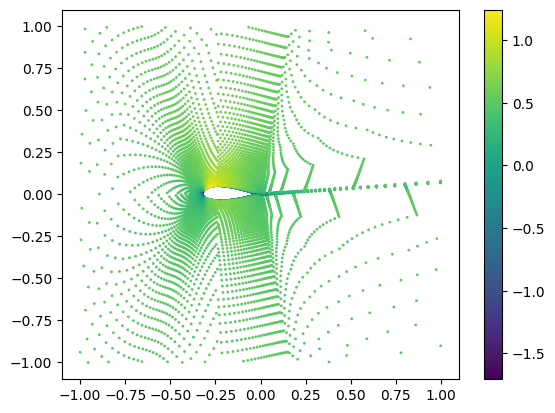

In [336]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

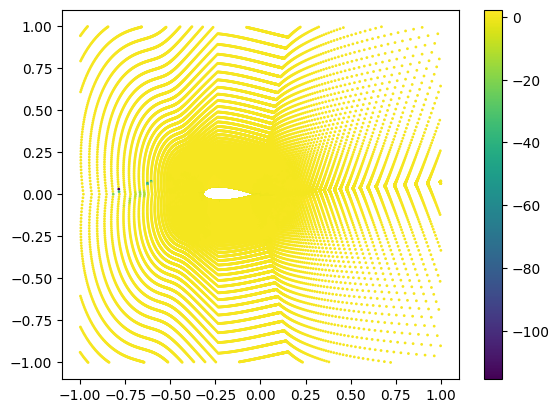

In [338]:
nef.eval()
pred = nef.velocity(coordinates)
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

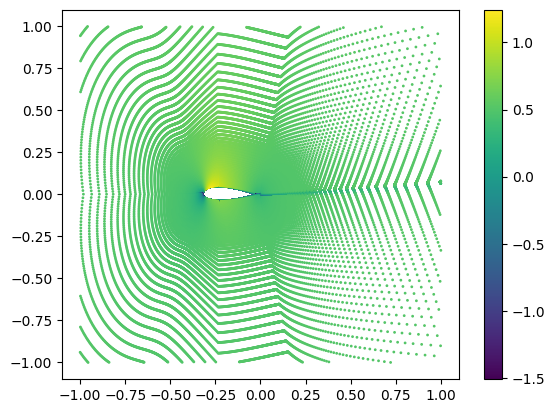

In [339]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=images.detach().cpu(), s=1)
plt.colorbar()

In [340]:
loss = ((images - pred)**2).mean()

In [341]:
loss

tensor(0.1227, device='cuda:0', grad_fn=<MeanBackward0>)

In [321]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [322]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [323]:
x_mask = (coordinates[..., 0] < 0.6) & (coordinates[..., 0] > 0.4)
y_mask = (coordinates[..., 1] < 0.6) & (coordinates[..., 1] > 0.4)
mask = x_mask & y_mask

In [324]:
coords_sub = (coordinates[mask] - 0.4)*100
images_sub = images_scaled[mask]

In [325]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.034475564956665
loss: 0.013061603531241417
loss: 0.007928073406219482
loss: 0.004260915331542492
loss: 0.0032179937697947025
loss: 0.0033631008118391037
loss: 0.0023756169248372316
loss: 0.0017124955775216222
loss: 0.0019903641659766436
loss: 0.002891495358198881
loss: 0.0009753579506650567
loss: 0.0012166238157078624
loss: 0.0012091930257156491
loss: 0.001270992448553443
loss: 0.0014312054263427854
loss: 0.0009011279908008873
loss: 0.0018298239447176456
loss: 0.0017821554793044925
loss: 0.0006422006990760565
loss: 0.0006973950075916946
loss: 0.0013524823589250445
loss: 0.00138726772274822
loss: 0.0014934593345969915
loss: 0.0012435703538358212
loss: 0.0017909595044329762
loss: 0.0014233742840588093
loss: 0.0013678964460268617
loss: 0.0006341334083117545
loss: 0.0009100615861825645
loss: 0.000862468674313277
loss: 0.0013830516254529357
loss: 0.0015914434334263206
loss: 0.0013916543684899807
loss: 0.00035944324918091297
loss: 0.0005034864880144596
loss: 0.0008461619727313519
los

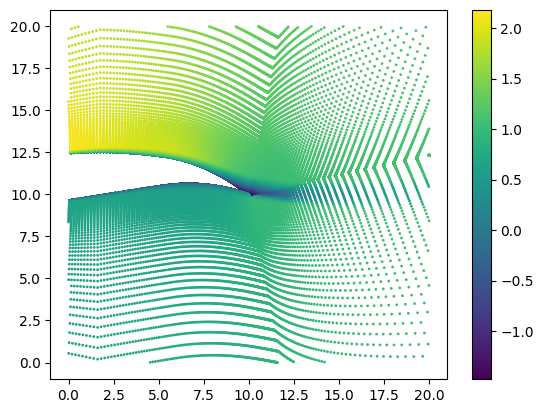

In [326]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

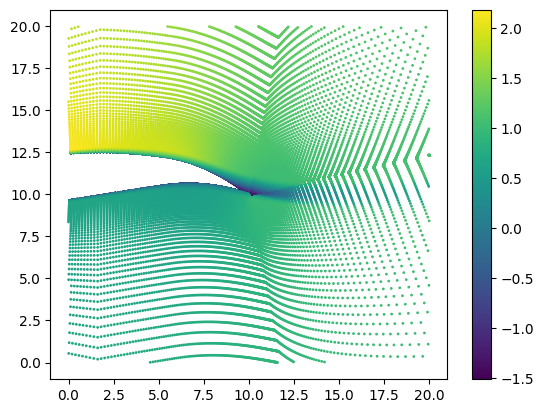

In [327]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [ ]:
coord_plt

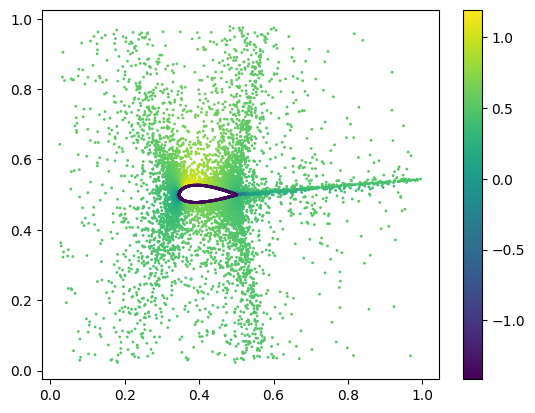

In [128]:
img_plt = images.detach().cpu()
pred_plt = pred.detach().cpu()
coord_plt = coordinates.detach().cpu()
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=img_plt, s=1)
plt.colorbar()

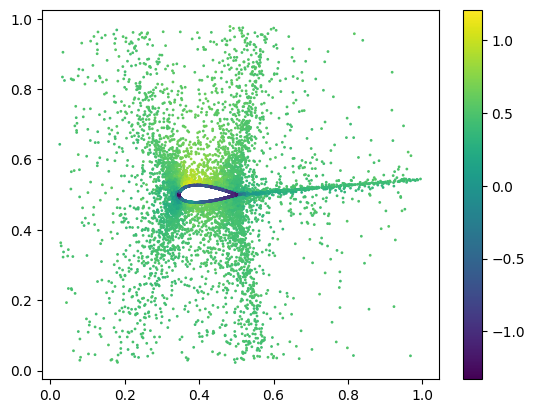

In [129]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=pred_plt*gamma, s=1)
plt.colorbar()

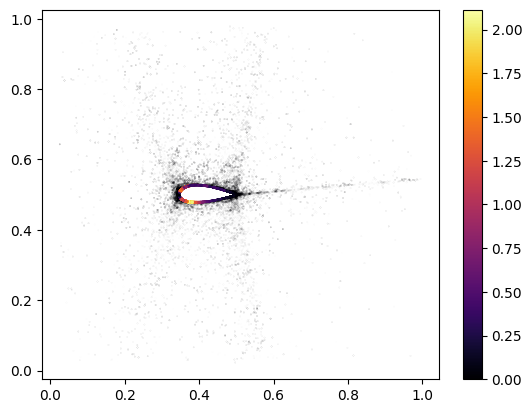

In [130]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=(pred_plt*gamma-img_plt)**2, s=(pred_plt*gamma-img_plt)**2, cmap="inferno")
plt.colorbar()

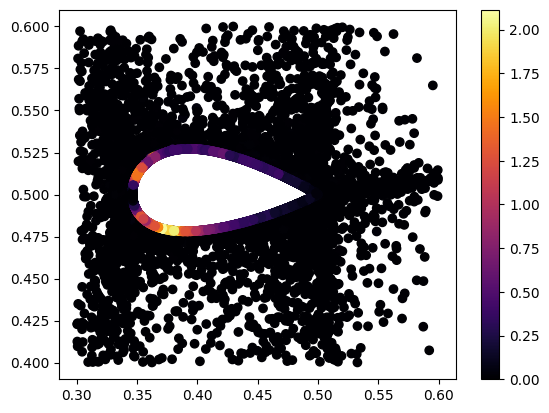

In [134]:
x_mask = (coord_plt[..., 0] < 0.6) & (coord_plt[..., 0] > 0.3)
y_mask = (coord_plt[..., 1] < 0.6) & (coord_plt[..., 1] > 0.4)
plot_mask = x_mask & y_mask
plt.scatter(coord_plt[plot_mask, 0], coord_plt[plot_mask, 1], c=((pred_plt*gamma-img_plt)**2)[plot_mask], cmap="inferno")
plt.colorbar()

In [184]:
from sklearn.cluster import KMeans

In [187]:
clustering_model = KMeans(n_clusters=128, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [ ]:
clustering_model.fit(gr